### Experiments with topic modeling as community detection in Gregorian chant repertoire data
First some parameter selection  

1. 2, 5, 10 and 20 topics for all data
2. evaluation via six czech sources

#### Common code

In [1]:
# Imports
import numpy as np
import pandas as pd

import lzma
import pickle

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, rand_score

from collections import Counter, OrderedDict
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'incipit', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path', 'siglum', 'cursus'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

chants = pd.concat([responsories_all, antiphons_all])

In [3]:
# Construct dict to index sources

source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1

In [4]:
# Transform chant data into document like structure
source_all_chants_dict = {}
used_cantus_ids = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants['source_id'] == source_id
    used_cantus_ids += (chants[filt_source]['cantus_id']).tolist()
    source_all_chants_dict[source_id] = ' '.join((chants[filt_source]['cantus_id']).tolist())

print("Number of chants in our sources", len(used_cantus_ids))
freq_CIDs = Counter(used_cantus_ids)
print(freq_CIDs.most_common()[:10])
print('Number of CIDs used in our sources', len(set(used_cantus_ids)))

Number of chants in our sources 362632
[('001328', 1009), ('005127', 661), ('003522', 600), ('001329', 560), ('001332', 525), ('001333', 510), ('001709', 432), ('003985', 432), ('001408', 395), ('001331', 389)]
Number of CIDs used in our sources 17599


In [5]:
def count_jaccard(community_variants, num_of_runs):
    friends_matrix = np.zeros([len(source_dict), len(source_dict)])
    for com_ver in community_variants:
        for com in com_ver:
            com = sorted(list(com))
            for pair in combinations(com, 2):
                friends_matrix[source_dict[pair[0]], source_dict[pair[1]]] += 1

    sig_level = round((np.sum(friends_matrix) / np.count_nonzero(friends_matrix)) / num_of_runs, 2)
    return sig_level

In [6]:
def count_rand(community_variants_labels):
    rand = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        rand.append(rand_score(pair[0], pair[1]))
        
    return(np.mean(rand))

In [7]:
def count_mutual(community_variants_labels):
    mutual = []
    all_pairs = [(a, b) for idx, a in enumerate(community_variants_labels) for b in community_variants_labels[idx + 1:]]
    for pair in all_pairs:
        mutual.append(mutual_info_score(pair[0], pair[1]))
        
    return(np.mean(mutual))

In [ ]:
# Piece of code to 
def show_main_words():
    pass

#### Choose CountVectorizer settings

In [8]:
# Plot of how maximal required document frequency affects number of CI while min_df fixed on extreme value
max_dfs = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250]
max_df_chants_dict = {}
for i in max_dfs:
    cv = CountVectorizer(max_df=i, min_df=0.0)
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    max_df_chants_dict[i] = cv_data.shape[1]

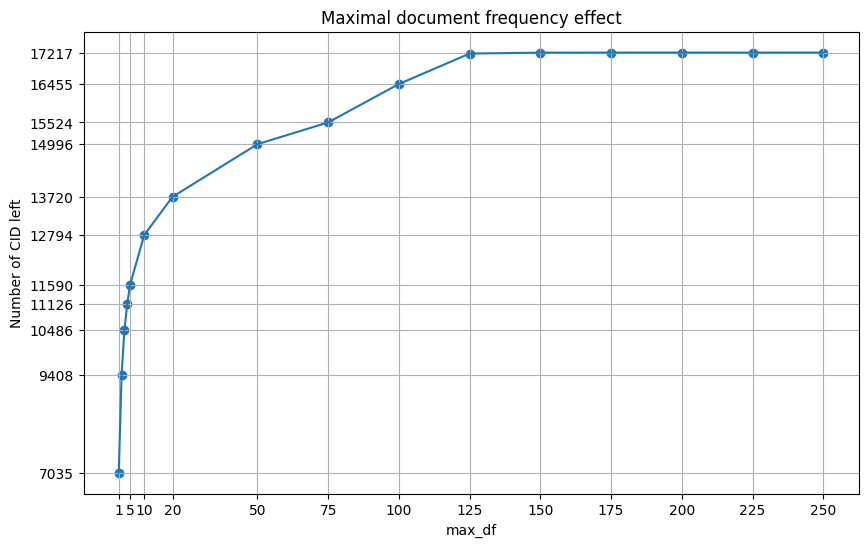

In [9]:
#plt.bar(x=max_df_chants_dict.keys(), height=max_df_chants_dict.values())
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(x=max_df_chants_dict.keys(), y=max_df_chants_dict.values())
plt.plot(max_df_chants_dict.keys(), max_df_chants_dict.values())
plt.title("Maximal document frequency effect")
plt.xticks([1, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 225, 250])
plt.yticks(list(max_df_chants_dict.values())[:-6] + [list(max_df_chants_dict.values())[-1]])
plt.xlabel("max_df")
plt.ylabel("Number of CID left")
plt.show()

In [10]:
# Plot of how minimal required document frequency affects number of CI while max_df fixed on extreme value
min_df_chants_dict = {}
for i in range(1, 21):
    cv = CountVectorizer(max_df=1.0, min_df=i)
    cv_data = cv.fit_transform(source_all_chants_dict.values())
    min_df_chants_dict[i] = cv_data.shape[1]

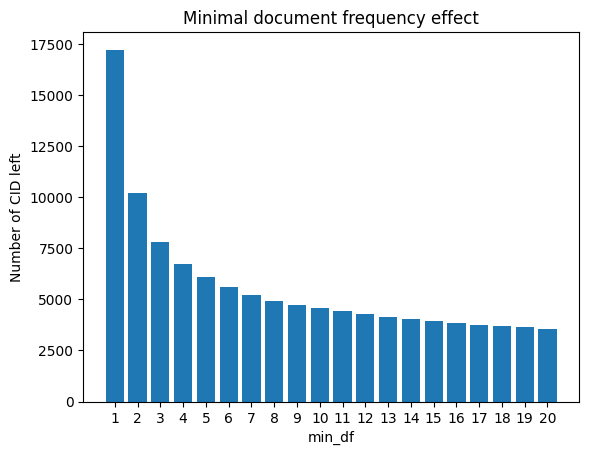

In [11]:
plt.bar(x=min_df_chants_dict.keys(), height=min_df_chants_dict.values())
plt.title("Minimal document frequency effect")
plt.xticks(list(min_df_chants_dict.keys()))
plt.xlabel("min_df")
plt.ylabel("Number of CID left")
plt.show()

##### Our three CountVectorizer possibilites

In [12]:
# Construct [sources x chants] matrix (document word matrix) for almost all data
all_count_vec = CountVectorizer(max_df=len(sources), min_df=0.0)
all_count_vec_data = all_count_vec.fit_transform(source_all_chants_dict.values())
print("Most wide [sources x chants] matrix shape:", all_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - all_count_vec_data.shape[1], "CIDs")

Most wide [sources x chants] matrix shape: (250, 17217)
Loosing 382 CIDs


In [13]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 200 or less docs and also it at least two docs
less_count_vec = CountVectorizer(max_df=200, min_df=2)
less_count_vec_data = less_count_vec.fit_transform(source_all_chants_dict.values())
print("Less wide [sources x chants] matrix shape:", less_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - less_count_vec_data.shape[1], "CIDs")

Less wide [sources x chants] matrix shape: (250, 10182)
Loosing 7417 CIDs


In [14]:
# Construct [sources x chants] matrix (document word matrix) for choosen data
# we use only words which are in 50 or less docs and also it at least two docs
smallest_count_vec = CountVectorizer(max_df=50, min_df=2)
smallest_count_vec_data = smallest_count_vec.fit_transform(source_all_chants_dict.values())
print("Less wide [sources x chants] matrix shape:", smallest_count_vec_data.shape)
print("Loosing", len(set(used_cantus_ids)) - smallest_count_vec_data.shape[1], "CIDs")

Less wide [sources x chants] matrix shape: (250, 7961)
Loosing 9638 CIDs


### Parameters search
max_iter  
CountVectorizer

In [20]:
# Run LDA for num_of_topics topics on all data with max_iter options in num_of_runs repeat 
# and return jaccard index of 

def LDA_basic_run(num_of_runs, num_of_topics, max_iter_options, cv, random_states):
    iter_metric_dict = {}
    for iter in max_iter_options:
        print(iter)
        community_variants = []
        community_variants_labels = []
        for i in range(num_of_runs):
            model = LatentDirichletAllocation(n_components=num_of_topics, max_iter=iter, evaluate_every=1, random_state=random_states[i])
            data_trans = cv.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
            result = model.fit_transform(data_trans)
            topics = result.argmax(axis=1)

            community_variants_labels.append(topics)

            restored_comm = {}
            for topic in range(num_of_topics):
                restored_comm[topic] = []

            for n in range(len(topics)):
                restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

            community_variants.append(restored_comm.values())

        iter_metric_dict[iter] = (count_jaccard(community_variants, num_of_runs), count_rand(community_variants_labels), count_mutual(community_variants_labels) )

    return iter_metric_dict

In [36]:
num_of_runs = 5
num_of_topics = [2, 5, 10, 20]
max_iter_options = [10, 20, 30, 40, 50]
cv_options = [all_count_vec, less_count_vec, smallest_count_vec]
cv_opt_string = ["all_count_vec", "less_count_vec", "smallest_count_vec"]
random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

#### max_iter effect

In [274]:
dicts_max_iter = {}
for t in num_of_topics:
    iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs, num_of_topics=t, max_iter_options=max_iter_options, cv=all_count_vec)
    dicts_max_iter[t] = iter_metrics_dict

10
20
30
40
50
10
20
30
40
50
10
20
30
40
50
10
20
30
40
50


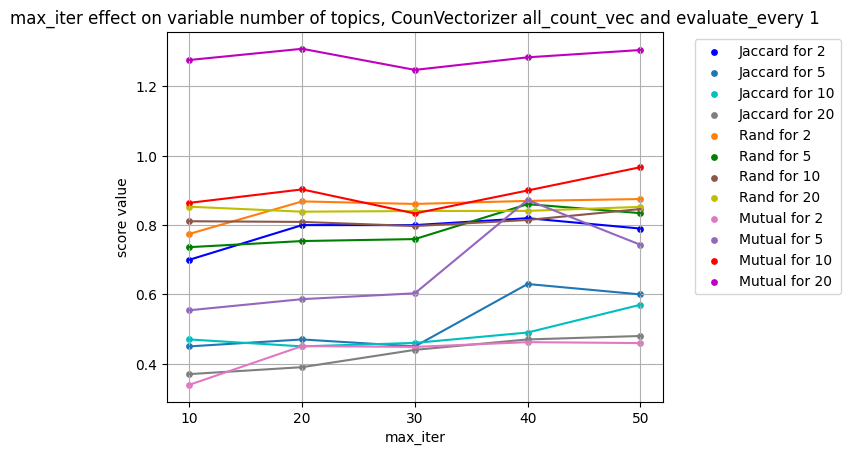

In [275]:
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
fig = plt.figure()
ax1 = fig.add_subplot(111)
j = 0
for i in num_of_topics:
    ax1.scatter(x=max_iter_options, y=[x[0] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j], marker="o", label='Jaccard for '+str(i))
    ax1.plot(max_iter_options, [x[0] for x in list(dicts_max_iter[i].values())], c=colors[j])
    j = j +3
j = 0
for i in num_of_topics:
    ax1.scatter(x=max_iter_options, y=[x[1] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j+1], marker="o", label='Rand for '+str(i))
    ax1.plot(max_iter_options, [x[1] for x in list(dicts_max_iter[i].values())], c=colors[j+1])
    j = j +3
j = 0
for i in num_of_topics:
    ax1.scatter(x=max_iter_options, y=[x[2] for x in list(dicts_max_iter[i].values())], s=15, c=colors[j+2], marker="o", label='Mutual for '+str(i))
    ax1.plot(max_iter_options, [x[2] for x in list(dicts_max_iter[i].values())], c=colors[j+2])
    j = j +3

plt.xlabel("max_iter")
plt.xticks(max_iter_options)
plt.ylabel("score value")
plt.title("max_iter effect on variable number of topics, CounVectorizer all_count_vec and evaluate_every 1")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### CountVectorizer effect

In [232]:
dicts_cv = {}
for t in num_of_topics:
    dicts_cv[t] = []
    for cv in cv_options:
        iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs, num_of_topics=t, max_iter_options=40, cv=cv)
        dicts_cv[t].append(iter_metrics_dict)

40
40
40
40
40
40
40
40
40
40
40
40


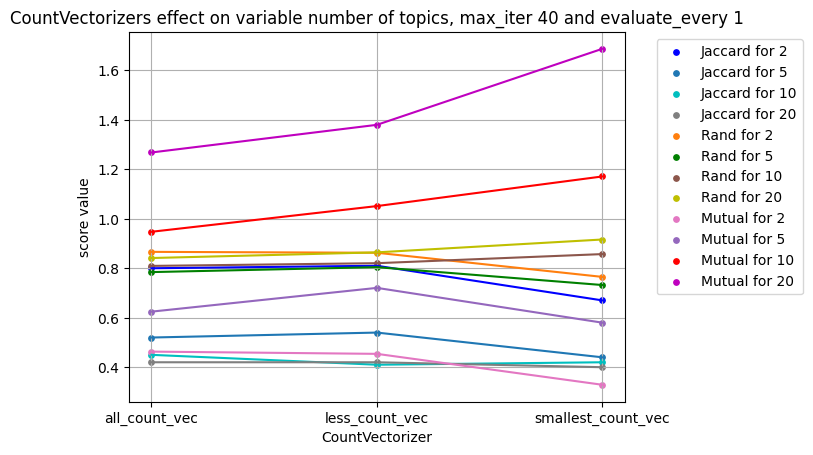

In [245]:
colors = ['b', 'tab:orange', 'tab:pink', 'tab:blue', 'g', 'tab:purple', 'c', 'tab:brown', 'r', 'tab:gray', 'y', 'm']
fig = plt.figure()
ax1 = fig.add_subplot(111)
j = 0
for i in num_of_topics:
    ax1.scatter(x=cv_opt_string, y=[x[40][0] for x in dicts_cv[i]], s=15, c=colors[j], marker="o", label='Jaccard for '+str(i))
    ax1.plot(cv_opt_string, [x[40][0] for x in dicts_cv[i]], c=colors[j])
    j = j +3
j = 0
for i in num_of_topics:
    ax1.scatter(x=cv_opt_string, y=[x[40][1] for x in dicts_cv[i]], s=15, c=colors[j+1], marker="o", label='Rand for '+str(i))
    ax1.plot(cv_opt_string, [x[40][1] for x in dicts_cv[i]], c=colors[j+1])
    j = j +3
j = 0
for i in num_of_topics:
    ax1.scatter(x=cv_opt_string, y=[x[40][2] for x in dicts_cv[i]], s=15, c=colors[j+2], marker="o", label='Mutual for '+str(i))
    ax1.plot(cv_opt_string, [x[40][2] for x in dicts_cv[i]], c=colors[j+2])
    j = j +3

plt.xlabel("CountVectorizer")
plt.xticks(cv_opt_string)
plt.ylabel("score value")
plt.title("CountVectorizers effect on variable number of topics, max_iter 40 and evaluate_every 1")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Four topic options on "best setting" - stability eval
evaluate_every = 1  
max_iter = 40  
CountVectorizer -> less_count_vec  
number of runs = 20 

In [37]:
dicts_topic = {}
num_of_runs_t = 20
for t in num_of_topics:
    print("topic", t)
    iter_metrics_dict = LDA_basic_run(num_of_runs=num_of_runs_t, num_of_topics=t, max_iter_options=[40], cv=less_count_vec, random_states=random_states)
    dicts_topic[t] = iter_metrics_dict

topic 2
40
topic 5
40
topic 10
40
topic 20
40


In [38]:
with lzma.open("all_top_20.txt", "wb") as model_file:
    pickle.dump(dicts_topic, model_file)

In [39]:
with lzma.open("all_top_20.txt", "rb") as model_file:
    dump_topic_dict = pickle.load(model_file)
print(dump_topic_dict)

{2: {40: (0.81, 0.8880209680828578, 0.48952743548642547)}, 5: {40: (0.36, 0.7956599450433312, 0.7145689100204103)}, 10: {40: (0.34, 0.8288566476432044, 1.0528748454912553)}, 20: {40: (0.27, 0.8567389558232932, 1.4057082515859847)}}


In [40]:
for t in dicts_topic.keys():
    print("Number of topics:", t)
    print("  max_iter =", 40)
    print("  CountVectorizer:", "less_count_vec")
    print("\t Jaccard index:", dicts_topic[t][40][0])
    print("\t Rand index:", dicts_topic[t][40][1])
    print("\t Mutual info score:", dicts_topic[t][40][2])
    print()

Number of topics: 2
  max_iter = 40
  CountVectorizer: less_count_vec
	 Jaccard index: 0.81
	 Rand index: 0.8880209680828578
	 Mutual info score: 0.48952743548642547

Number of topics: 5
  max_iter = 40
  CountVectorizer: less_count_vec
	 Jaccard index: 0.36
	 Rand index: 0.7956599450433312
	 Mutual info score: 0.7145689100204103

Number of topics: 10
  max_iter = 40
  CountVectorizer: less_count_vec
	 Jaccard index: 0.34
	 Rand index: 0.8288566476432044
	 Mutual info score: 1.0528748454912553

Number of topics: 20
  max_iter = 40
  CountVectorizer: less_count_vec
	 Jaccard index: 0.27
	 Rand index: 0.8567389558232932
	 Mutual info score: 1.4057082515859847



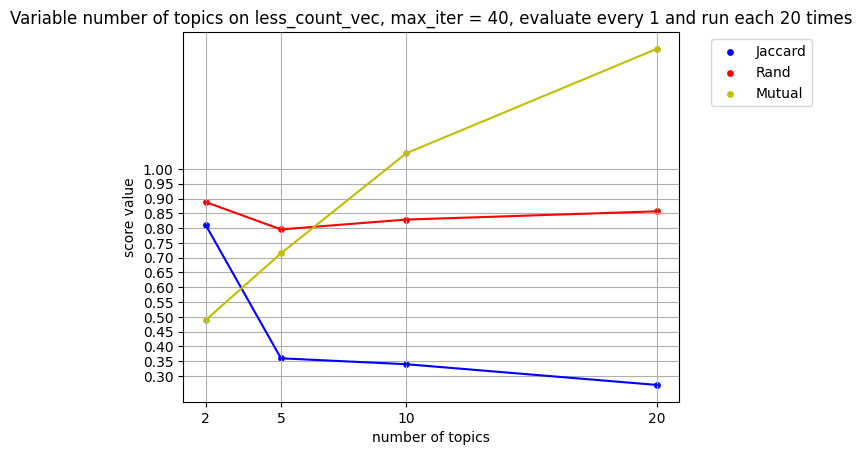

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=num_of_topics, y=[x[40][0] for x in list(dicts_topic.values())], s=15, c='b', marker="o", label='Jaccard')
ax1.plot(num_of_topics, [x[40][0] for x in list(dicts_topic.values())], c='b')

ax1.scatter(x=num_of_topics, y=[x[40][1] for x in list(dicts_topic.values())], s=15, c='r', marker="o", label='Rand')
ax1.plot(num_of_topics, [x[40][1] for x in list(dicts_topic.values())], c='r')

ax1.scatter(x=num_of_topics, y=[x[40][2] for x in list(dicts_topic.values())], s=15, c='y', marker="o", label='Mutual')
ax1.plot(num_of_topics, [x[40][2] for x in list(dicts_topic.values())], c='y')

plt.xlabel("number of topics")
plt.xticks(num_of_topics)
plt.ylabel("score value")
plt.yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Variable number of topics on less_count_vec, max_iter = 40, evaluate every 1 and run each 20 times")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Czech sources for possible evaluation

In [43]:
six_czech_sources = {"http://cantusbohemiae.cz/source/33177" : "CZ-Pn XII A 24", 
                      "http://cantusbohemiae.cz/source/4478" : "CZ-Pu Pu XIV A 19", 
                      "http://cantusbohemiae.cz/source/28509" : "XV A 10",
                      "http://cantusdatabase.org/source/123730" : "CZ-Pu XIV B 13", 
                      "http://cantusdatabase.org/source/123727" : "CZ-Pu VI.E.4c", 
                      "http://cantusbohemiae.cz/source/28488" : "CZ-Pu VI G 11"}

In [44]:
cathedral_used_feats = []
for sI in list(six_czech_sources.keys())[:3]:
    print(sI, len(chants[chants['source_id'] == sI]))
    cathedral_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

# Cathedral field
freqC = Counter(cathedral_used_feats)
three_cathedral_feasts = []
for key in freqC.keys():
    if freqC[key] >=3:
        three_cathedral_feasts.append(key)

# George monastery
monastery_used_feats = []
for sI in list(six_czech_sources.keys())[3:]:
    print(sI, len(chants[chants['source_id'] == sI]))
    monastery_used_feats += set(chants[chants['source_id'] == sI]['feast_id'].dropna().tolist())

freqM = Counter(monastery_used_feats)
three_monastery_feasts = []
for key in freqM.keys():
    if freqM[key] >= 3:
        three_monastery_feasts.append(key)

complete_feasts = set(three_cathedral_feasts).intersection(set(three_monastery_feasts))
print("Number of feast in all six sources:", len(complete_feasts))

http://cantusbohemiae.cz/source/33177 582
http://cantusbohemiae.cz/source/4478 988
http://cantusbohemiae.cz/source/28509 1741
http://cantusdatabase.org/source/123730 1403
http://cantusdatabase.org/source/123727 2327
http://cantusbohemiae.cz/source/28488 2616
Number of feast in all six sources: 37


In [48]:
# Take GOOD 2 topics model and ask about each complete_faest feast data
number_of_topics = 2
CZmodel = LatentDirichletAllocation(n_components=number_of_topics, evaluate_every=1, max_iter=40, random_state=436)
data_trans = all_count_vec.fit_transform([source_all_chants_dict[s] for s in sources['drupal_path'].tolist()])
CZmodel.fit(data_trans)

LatentDirichletAllocation(evaluate_every=1, max_iter=40, n_components=2,
                          random_state=436)

In [66]:
feast_used_sources = []
each_feast_source_chants_dict = {}
for feast in complete_feasts:
    each_feast_source_chants_dict[feast] = {}
    feast_chants = chants[chants['feast_id'] == feast]
    for source in feast_chants['source_id']:
        feast_used_sources.append(source)
        each_feast_source_chants_dict[feast][source] = ' '.join(feast_chants[feast_chants['source_id'] == source]['cantus_id'].tolist())

In [68]:
print(len(set(feast_used_sources)))

248


In [51]:
feast_communities = {}
for feast in complete_feasts:
    feast_trans_data = all_count_vec.transform(each_feast_source_chants_dict[feast].values())
    result = CZmodel.transform(feast_trans_data)
    topics = result.argmax(axis=1)

    restored_comm = {}
    for topic in range(number_of_topics):
        restored_comm[topic] = []

    for n in range(len(topics)):
        restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

    feast_communities[feast] = (restored_comm.values())

In [52]:
feast_source_chants_dict = {}
feast_used_cantus_ids = []
for source_id in sources['drupal_path'].tolist():
    filt_source = chants[chants['source_id'] == source_id]
    feast_used_cantus_ids += (filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist()
    feast_source_chants_dict[source_id] = ' '.join((filt_source[filt_source['feast_id'].isin(complete_feasts)]['cantus_id']).tolist())

print('Number of cantus_ids used in our sources:', len(set(feast_used_cantus_ids)))

Number of cantus_ids used in our sources: 1224


In [53]:
feast_trans_data = all_count_vec.transform(feast_source_chants_dict.values())
result = CZmodel.transform(feast_trans_data)
topics = result.argmax(axis=1)

restored_comm = {}
for topic in range(number_of_topics):
    restored_comm[topic] = []

for n in range(len(topics)):
    restored_comm[topics[n]].append(sources['drupal_path'].tolist()[n])

In [65]:
for com in restored_comm.keys():
    print(len(restored_comm[com]), [sources[sources['drupal_path'] == s]['siglum'].tolist() for s in restored_comm[com]])

244 [['I-BV V 19'], ['CH-E 611'], ['CH-SGs 388'], ['CH-SGs 391'], ['D-B Mus. 40047'], ['I-Far'], ['I-Fl Conv. sopp. 560'], ['CH-Fco Ms. 2'], ['D-MZb D'], ['D-Ma 12o Cmm 1'], ['D-Mbs Clm 4305'], ['D-Mbs Clm 4306'], ['D-W 28 Helmst.'], ['E-SA 7'], ['E-Tc 44.1'], ['E-Tc 44.2'], ['F-Pn Lat. 1090'], ['F-Pn Lat. 12601'], ['F-VAL 114'], ['GB-AB 20541 E'], ['GB-Cu Mm.ii.9'], ['GB-WO F.160'], ['GB-WO F.160 (Facs)'], ['H-Bu lat. 121'], ['HR-Hf Cod. E'], ['I-Ac 693'], ['I-Ac 694'], ['I-Ad 5'], ['I-Nn vi.E.20'], ['I-Rv C.5'], ['V-CVbav Vat.lat. 8737'], ['NL-Uu 406 (3 J 7)'], ['NL-ZUa 6'], ['NZ-Wt MSR-03'], ['PL-Kkar 1 (Rkp 12)'], ['PL-Kkar 3 (Rkp 15)'], ['US-Cn 24'], ['V-CVbav B.79'], ['P-BRs Ms. 028'], ['MsEPl 15'], ['ms. 4'], ['E-SI ms. 9'], ['E-LUc s.s.'], ['E-Bbc E-Bbc, Ms. 619'], ['A-Gu 30'], ['A-KN 1012'], ['A-KN 1018'], ['A-KN 589'], ['A-KR VI/258'], ['A-LIs 290'], ['A-SF XI 480'], ['A-VOR 287'], ['A-Wn 1799**'], ['A-Wn 1890'], ['B-Gu Hs BKT.006'], ['D-AAm G 20'], ['D-KA Aug. LX'], ['D-Sl H

### Provenance union